# Abstract for the Project

## Task

The task is to test which model architecture performs best at imdb sentiment classification.

## Model

The models utilize BERT embeddings and various combinations of lstm , cnn , and graph techniques.

## Experiment

The experiments are in progress. We are looking for accuracy, failure points, and interpretability. The goal is to test for full data, limited data, and limited label scenarios.

## Datasets

The main dataset is the IMDB movie reviews and whatever was used to produce the BERT embeddings.

# Code

## Import Statements

In [ ]:
# !pip install -U tensorflow-text==2.8.1

In [ ]:
# !pip install neural_structured_learning

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import neural_structured_learning as nsl
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [8]:
import dataLoader
import bertEmbeddings
import tfRecordTools
import train
import importlib
import models

## Dataset Loading

In [9]:
# Load data from IMDB
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000, seed=12345))

print(pp_train_data.shape)

(25000,)


In [10]:
# This block limits how much is loaded to keep debugging short
# don't run on the final experiments

limit = 25000

pp_train_data = pp_train_data[0:limit]
pp_train_labels = pp_train_labels[0:limit]
pp_test_data = pp_test_data[0:limit]
pp_test_labels = pp_test_labels[0:limit]

In [11]:
# Print data entries
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data),
    len(pp_train_labels)
))
training_samples_count = len(pp_train_data)
print(pp_train_data[0])
len(pp_train_data[0]), len(pp_train_data[1])

Training entries: 25000, labels: 25000
[1, 31, 7, 4, 55, 118, 289, 4656, 3153, 126, 6, 3642, 313, 368, 7, 445, 493, 5, 4, 2, 2932, 4, 4430, 1255, 2, 118, 349, 2, 9, 11, 350, 812, 11, 4, 804, 11, 4, 465, 136, 2, 2, 1568, 321, 1425, 11, 27, 443, 2, 217, 17, 4, 2401, 7, 6, 588, 114, 159, 45, 120, 2, 2, 117, 2, 9, 5652, 8, 87, 962, 14, 3248, 786, 1528, 1102, 44, 17, 702, 17, 101, 2, 346, 5, 6510, 1453, 4, 2, 545, 1178]


(87, 112)

In [12]:
reverseWordIndex = dataLoader.buildReverseWordIndex(imdb)

In [13]:
dataLoader.decodeReview(pp_train_data[0], reverseWordIndex)

"<START> one of the very best three stooges shorts ever a spooky house full of evil guys and the <UNK> challenge the alert detective <UNK> best men <UNK> is in top form in the famous in the dark scene <UNK> <UNK> provides excellent support in his mr <UNK> role as the target of a murder plot before it's over <UNK> <UNK> little <UNK> is employed to great effect this 16 minute gem moves about as fast as any <UNK> short and packs twice the <UNK> highly recommended"

## Pretrained Embeddings

In [14]:
# Retrieve small bert embeddings
pretrained_embedding = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2'

In [15]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2',trainable=True)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].

sequence_output = outputs['sequence_output'] #[batch_size, seq_length, 128].

### Pretrained Multi-layer Embeddings for CNN

In [16]:
# For testing now. Will be moved to bertEmbeddings.py later.
def createBertMultilayerEmbedding(wordVectors, labels, outputPath, startingRecordId, reverseWordIndex, encoder, preprocessor, num_layers):
    """
    Create full set of BERT embeddings including the output of hidden BERT layers

    Args:
        wordVectors - (np.ndarray) all text to decode
        outputPath - (string) path to output file
        startingRecordId - (int) ID of the first sample
        reverseWordIndex - (dict) The reverse word index to use
        encoder - (string) encoder name
        preprocessor - (string) preprocessor name
        num_layers - (list of int) numbers of embedding layers selected [start, step]
    Returns:
        recordID - (int) ID of the last sample
    """
    recordID = int(startingRecordId)
    with tf.io.TFRecordWriter(outputPath) as writer:
        for word_vector, label in zip(wordVectors, labels):
            text = dataLoader.decodeReview(word_vector, reverseWordIndex)
            
            allEmbedding = encoder(preprocessor(tf.reshape(text, shape=[-1, ])))['encoder_outputs'][num_layers[0]::num_layers[1]]
            encoder_outputs = np.array([i.numpy() for i in allEmbedding])
            encoder_outputs = np.squeeze(encoder_outputs, axis=1)
            sentenceEmbedding = tf.reshape(encoder_outputs, shape=[-1,])
            
            features = {
                'id': tfRecordTools.bytesFeature(str(recordID)),
                'words': tfRecordTools.floatFeature(sentenceEmbedding.numpy()),
                'label':tfRecordTools.int64Feature(np.asarray([label]))
            }

            example = tf.train.Example(features=tf.train.Features(feature=features))

            recordID = recordID + 1
            writer.write(example.SerializeToString())
    return recordID

In [17]:
# numbers of embedding layers selected: [start, step], until the last hidden layer

num_embedding_layers = [-4,1]

multiEmbeddingPath = './imdb/embed_'+ str(limit) + '_'

In [18]:
# Following lines generate the embeddings of imdb reviews, which will take some time.
# If you have already run the following two blocks before (i.e. already have the files generated), just skip them.

In [34]:
print("Creating Small BERT embeddings of whole dataset (25000 reviews) takes about 20 minutes.")

createBertMultilayerEmbedding(pp_train_data, pp_train_labels, multiEmbeddingPath+"train_data.tfr", 0, reverseWordIndex, encoder, preprocessor, num_embedding_layers)

Creating Small BERT embeddings of whole dataset (25000 reviews) takes about 20 minutes.


25000

In [35]:
createBertMultilayerEmbedding(pp_test_data, pp_test_labels, multiEmbeddingPath+"test_data.tfr", 0, reverseWordIndex, encoder, preprocessor, num_embedding_layers)

25000

## Training and Validation

### Training Hyperparameters

In [19]:
class HParams(object):
    """
    Hyperparameters used for training.
    """
    def __init__(self):
        
        # Following params are for baseline models
        
        # dataset parameters
        self.num_classes = 2
        self.max_seq_length = 256
        self.vocab_size = 10000
        # neural graph learning parameters
        self.distance_type = nsl.configs.DistanceType.L2
        self.graph_regularization_multiplier = 0.1
        self.num_neighbors = 2
        # model architecture
        self.num_embedding_dims = 16
        self.num_lstm_dims = 64
        self.num_fc_units = 64
        # training parameters
        self.train_epochs = 20
        self.batch_size = 32
        # eval parameters
        self.eval_steps = None  # All instances in the test set are evaluated.

        # Following params are for CNN
        
        self.num_embedding_layers = 4 #according to the pretrained bert
        self.embed_max_seq = 128
        self.embed_size = 512  #according to the pretrained bert

        self.filter_sizes = [3,5,7]       # [3,5,7]
        self.num_filters = 256           # [64,128,256]
        
        self.cnn_learning_rate = 3e-4
        self.dropout_rate = 0.4
        self.dense_units = 64          # [128,256,512]

HPARAMS = HParams()

### Build Traininig and Testing Datasets

In [25]:
def makeEmbedDataset(filePath, HPARAMS, Training=False):
    def parseEmbedExample(exampleProto):
        feature_spec = {
                'words': tf.io.VarLenFeature(tf.float32),
                'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
            }
        features = tf.io.parse_single_example(exampleProto, feature_spec)
        # features['words'] = features['words'].values

        # feature_length changes based on pretrained model we use
        feature_length = HPARAMS.num_embedding_layers * HPARAMS.embed_max_seq * HPARAMS.embed_size
        features['words'] = padEmbedSequence(features['words'], feature_length)

        labels = features.pop('label')
        return features, labels

    def padEmbedSequence(sequence, maxSeqLength):
        """Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`."""
        pad_size = tf.maximum([0], maxSeqLength - tf.shape(sequence)[0])
        padded = tf.concat(
            [sequence.values,
            tf.fill((pad_size), tf.cast(0, sequence.dtype))],
            axis=0)
        # The input sequence may be larger than max_seq_length. Truncate down if
        # necessary.
        return tf.slice(padded, [0], [maxSeqLength])

    dataset = tf.data.TFRecordDataset([filePath])

    dataset = dataset.map(parseEmbedExample)
    dataset = dataset.batch(HPARAMS.batch_size)

    return dataset

In [26]:
embedded_train_dataset = makeEmbedDataset(multiEmbeddingPath+"train_data.tfr", HPARAMS, True)

In [27]:
embedded_test_dataset = makeEmbedDataset(multiEmbeddingPath+"test_data.tfr", HPARAMS, False)

### Build Validation Set

In [28]:
validation_fraction = 0.2
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
embeded_validation_dataset = embedded_train_dataset.take(validation_size)
embedded_train_dataset = embedded_train_dataset.skip(validation_size)

156


## BERT CNN Model

### Create Model

In [29]:
HPARAMS.batch_size, HPARAMS.num_embedding_layers, HPARAMS.embed_max_seq, HPARAMS.embed_size, HPARAMS.num_embedding_layers*HPARAMS.embed_max_seq*HPARAMS.embed_size

(32, 4, 128, 512, 262144)

In [30]:
# For testing now. Will be moved to models.py later.
def makeCnnModel(HPARAMS):
    """
    Builds a CNN model.
    """

    inputs = tf.keras.Input(
        shape=(HPARAMS.num_embedding_layers*HPARAMS.embed_max_seq*HPARAMS.embed_size,),
        dtype='float32',
        name='words')

    embeddings = tf.reshape(inputs, shape=[-1,HPARAMS.num_embedding_layers,HPARAMS.embed_max_seq,HPARAMS.embed_size])
    print(embeddings)
    convolved_layers = []
    for K in HPARAMS.filter_sizes:
        convolved = tf.keras.layers.Conv2D(filters=HPARAMS.num_filters, kernel_size=(K,HPARAMS.embed_size),
                padding='valid', data_format='channels_first', activation='relu',
                input_shape=(HPARAMS.embed_size,HPARAMS.embed_size,HPARAMS.num_embedding_layers))(embeddings)
        convolved_layers.append(convolved)
        # convolved_layers.append(tf.reshape(convolved, shape=[-1, convolved.shape[1], convolved.shape[2]]))
    
    # should reduce dim before feed to maxpool1d
    max_pooled_layers = []
    for layer in convolved_layers:
        # max_pooled = tf.keras.layers.MaxPooling2D(pool_size=(layer.shape[1],layer.shape[2]))(layer)
        max_pooled = tf.keras.layers.MaxPooling2D(pool_size=(1,layer.shape[2]))(layer)
        max_pooled_layers.append(max_pooled)

        # remove
        # max_pooled_layers.append(layer)

    concat = tf.keras.layers.Concatenate(axis=1)(max_pooled_layers)

    outputs = tf.reshape(concat, shape=[-1,concat.shape[1]])

    # outputs = tf.keras.layers.Dropout(0.1)(outputs)

#     outputs = tf.keras.layers.Dense(HPARAMS.dense_units,activation='relu')(outputs)
    outputs = tf.keras.layers.Dense(HPARAMS.dense_units)(outputs)

    outputs = tf.keras.layers.Dropout(HPARAMS.dropout_rate)(outputs)

    outputs = tf.keras.layers.Dense(1,activation='sigmoid')(outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
tf.keras.backend.clear_session()
CnnModel = makeCnnModel(HPARAMS)
CnnModel.summary()

In [32]:
# set loss function and optimizer
cnn_optimizer = tf.keras.optimizers.Adagrad(learning_rate=HPARAMS.cnn_learning_rate)
CnnModel.compile(
    # optimizer='rmsprop',
    optimizer=cnn_optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])


In [33]:
model_all_historys = []

### Fit Model

In [ ]:
history = CnnModel.fit(
    embedded_train_dataset,
    validation_data=embeded_validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

In [36]:
model_all_historys.append(history)
len(model_all_historys)

1

### Evaluate Model

In [37]:
# evaluate model performance on testing set
test_results = CnnModel.evaluate(embedded_test_dataset, steps=HPARAMS.eval_steps)
print(test_results)

782/782 [==============================] - 44s 57ms/step - loss: 0.3656 - accuracy: 0.8384
[0.36561721563339233, 0.8383600115776062]


### Plot Performance


In [ ]:
# plot training and validaiton loss over epochs

acc, val_acc, loss, val_loss = [], [], [], []

for i in range(len(model_all_historys)):
    history_dict = model_all_historys[i].history
    acc += history_dict['accuracy']
    val_acc += history_dict['val_accuracy']
    loss += history_dict['loss']
    val_loss += history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

# plot training and validation accuracy over epochs

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

### Analysis

In [74]:
# get predictions

test_predict = CnnModel.predict(embedded_test_dataset)
predictions = np.squeeze(np.where(test_predict>0.5, 1, 0))

In [75]:
# Make sure that the labels of prediction and original test_labels are in the same order

correct_idx = np.where(predictions == pp_test_labels)[0]
incorrect_idx = np.where(predictions != pp_test_labels)[0]
print('Accuracy:', correct_idx.shape[0]/25000)

Accuracy: 0.83836


[[0.42376 0.07624]
 [0.0854  0.4146 ]]


<AxesSubplot:>

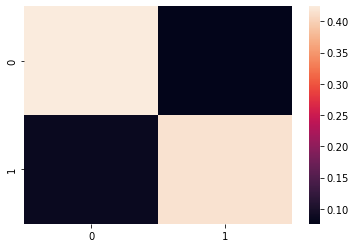

In [76]:
# Confusion Marix

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(pp_test_labels, predictions, normalize='all')
print(matrix)
sns.heatmap(matrix)

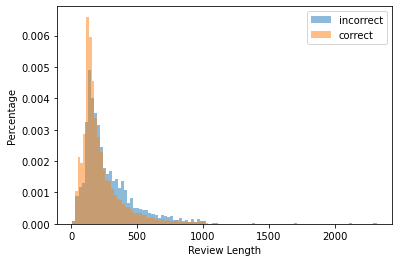

In [77]:
# Show the length of correct and incorrect classification

correct_length=[len(pp_test_data[i]) for i in correct_idx]
incorrect_length=[len(pp_test_data[i]) for i in incorrect_idx]
incrt = plt.hist(incorrect_length, bins=100, density=True, label='incorrect',alpha=0.5)
crt = plt.hist(correct_length, bins=100, density=True, label='correct',alpha=0.5)
plt.xlabel('Review Length')
plt.ylabel('Percentage')
plt.legend()
plt.show()


In [78]:
# Show some samples

print('-------- Correct samples: --------')
print('0 for negative, 1 for positive')

for i in range(100):
    sample_idx = correct_idx[i]
    print('\n#', i, ', label', pp_test_labels[sample_idx])
    if len(pp_test_data[sample_idx]) <= 256:
        print(dataLoader.decodeReview(pp_test_data[sample_idx], reverseWordIndex),"|||")
    else:
        print(dataLoader.decodeReview(pp_test_data[sample_idx][:256], reverseWordIndex),"|||",
              dataLoader.decodeReview(pp_test_data[sample_idx][256:], reverseWordIndex))

-------- Correct samples: --------
0 for negative, 1 for positive

# 0 , label 0
<START> i could not watch more than 10 minutes of this movie it has set the standard i will never again give a movie a 1 unless it was as horrible as this one i fully agree with the other comments about this film but since i'm dutch i watched it with dutch translation apparently they didn't have money for a proper translation so they decided to <UNK> it with sometimes hilarious results br br don't smoke don't drink don't do drugs don't watch demon summer br br i was surprised that the actors wow i can't believe i just said that didn't hold the script was there any in their hands while shooting i think they also did a good job on well no they didn't do a good job at all |||

# 1 , label 0
<START> take a cliché story and insert steve <UNK> need i say anymore this truly is as bad as you would expect sheriff tom <UNK> <UNK> and anna attempt to <UNK> a group of useless inept kids into a winning soccer team lack

In [79]:
print('-------- Incorrect samples: --------')
print('0 for negative, 1 for positive')

for i in range(100):
    sample_idx = incorrect_idx[i]
    print('\n#', i, ', label', pp_test_labels[sample_idx], ', prediction', predictions[sample_idx])
    if len(pp_test_data[sample_idx]) <= 256:
        print(dataLoader.decodeReview(pp_test_data[sample_idx], reverseWordIndex),"|||")
    else:
        print(dataLoader.decodeReview(pp_test_data[sample_idx][:256], reverseWordIndex),"|||",
              dataLoader.decodeReview(pp_test_data[sample_idx][256:], reverseWordIndex))

-------- Incorrect samples: --------
0 for negative, 1 for positive

# 0 , label 0 , prediction 1
<START> documentary content amazing man amazing movement he started amazing stories most of them yet to be really told br br celluloid treatment <UNK> ad sorry ain't got nothing else to say about this but that you can say all you want about the dire circumstances in the <UNK> but if you attempt to support that claim with flashy and <UNK> images and camera work of that life the <UNK> necessary to show this life as an <UNK> filmmaker goes out the window and with that goes the <UNK> of the narrative besides that the time space <UNK> in the film is all off and i'm not necessarily against that in films as a tool but here it serves only to confuse the viewer into wondering what was said when thus leading me to the question is this a documentary or a <UNK> br br <UNK> com |||

# 1 , label 0 , prediction 1
<START> to some of us director <UNK> lubitsch <UNK> for his underlying and ironic comic touc